In [1]:
from pipeline import pipeline
from chris import ldData, mlpClassification, makeTrainValSet, balanceStupid, NO_DISPLAY_savePred, mlpConvolution, medmeanFeatures, biosppyECG
from operator import itemgetter
import matplotlib.pyplot as plt
import numpy as np
from heinrich import inv, crop, ecgExtract, rfClassification
from anova import anova

# Evaluate Model

In [2]:
hyper = { 
    
    "inv_threshold": 0.6, 
    "crop_location": 300,
    "mlpClassification_epochs": 200,
    "mlpClassification_useValidationSet": True,
    "mlpClassification_makePrediction": False,
    "mlpConvolution_epochs": 200,
    "mlpConvolution_useValidationSet": True,
    "mlpConvolution_makePrediction": True,
    "makeTrainValSet_valPercent": 0.1,
    "rfClassification_depth": 3,
    "rfClassification_useValidationSet": True,
    "rfClassification_makePrediction": False,
    "anova_percentage": 0.7
}

data = pipeline([ ldData, crop, inv, biosppyECG, medmeanFeatures,balanceStupid, makeTrainValSet, mlpConvolution ], hyper )
print( "train losses" )
plt.plot( data[ "train_losses" ], color = "blue" )
print( "val losses" )
plt.plot( data[ "val_losses" ], color = "green" )

[Pipeline] Saved state found: ./cache/ldData()_crop(300)_inv(0.6)_biosppyECG()_medmeanFeatures(True,True,1)_balanceStupid()_makeTrainValSet(0.1), starting from function: mlpConvolution
[Pipeline] executing: mlpConvolution(200,True,True)
using device cpu
	Epoch 0 | Batch 0 | Loss   0.21
	Epoch 0 | Batch 40 | Loss   0.47
	Epoch 0 | Batch 80 | Loss   0.58
	Epoch 0 | Batch 120 | Loss   0.42
	Epoch 0 | Batch 160 | Loss   0.42
	Epoch 0 | Batch 200 | Loss   0.15
	Epoch 0 | Batch 240 | Loss   0.39
	Epoch 0 | Batch 280 | Loss   0.52
	Epoch 0 | Batch 320 | Loss   0.51
--- TRAINING Epoch 0 | Loss   0.42
--- VALIDATION Epoch 0 | Loss 0.47801

	Epoch 1 | Batch 0 | Loss   0.50
	Epoch 1 | Batch 40 | Loss   0.50
	Epoch 1 | Batch 80 | Loss   0.49
	Epoch 1 | Batch 120 | Loss   0.49
	Epoch 1 | Batch 160 | Loss   0.49
	Epoch 1 | Batch 200 | Loss   0.53
	Epoch 1 | Batch 240 | Loss   0.52
	Epoch 1 | Batch 280 | Loss   0.52
	Epoch 1 | Batch 320 | Loss   0.52
--- TRAINING Epoch 1 | Loss   0.49
--- VALIDATION 

KeyboardInterrupt: 

In [6]:
torch.cuda

<module 'torch.cuda' from '/usr/local/share/miniconda/lib/python3.9/site-packages/torch/cuda/__init__.py'>

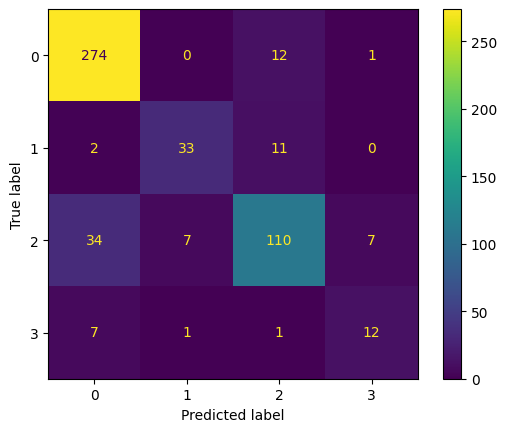

In [4]:
from olin_utils import confMat
_, misclass = confMat( data[ "y_val_hat" ], np.transpose( data[ "y_val" ])[ 0 ], visualize = True )

# Predict

[Pipeline] Saved state found: ./cache/ldData()_crop(300)_inv(0.6)_ecgExtract()_anova(0.7), starting from function: rfClassification
[Pipeline] executing: rfClassification(3,False,True)


/usr/local/share/miniconda/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[Pipeline] executing: NO_DISPLAY_savePred()
train losses


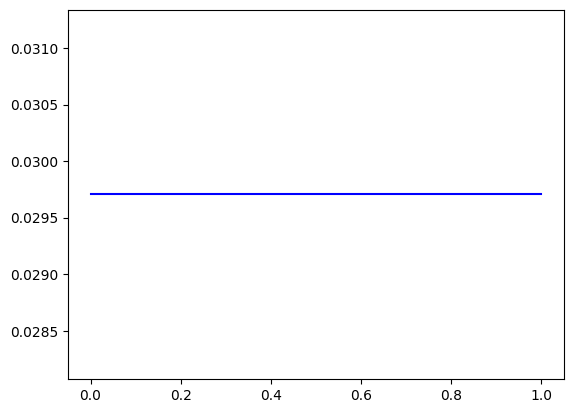

In [17]:
hyper = { 
    
    "inv_threshold": 0.6, 
    "crop_location": 300,
    "mlpClassification_epochs": 150,
    "mlpClassification_useValidationSet": False,
    "mlpClassification_makePrediction": True,
    "makeTrainValSet_valPercent": 0.1,
    "rfClassification_depth": 3,
    "rfClassification_useValidationSet": False,
    "rfClassification_makePrediction": True,
    "anova_percentage": 0.7
}

data = pipeline([ ldData, crop, inv, ecgExtract, anova, rfClassification, NO_DISPLAY_savePred ], hyper )
print( "train losses" )
plt.plot( data[ "train_losses" ], color = "blue" )